In [27]:
import json
import pandas as pd
from rdkit import Chem
from tqdm import tqdm
from matchms.importing import load_from_mgf
from matchms.exporting import save_as_mgf

### Standardize SMILES

31555


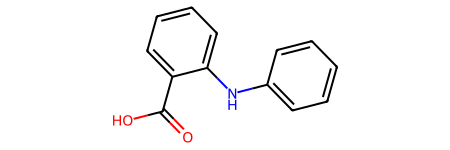

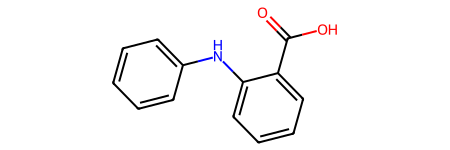

In [2]:
with open('../data/all_smiles.json', 'r') as f:
    smiles_in = json.load(f)
print(len(smiles_in))
with open('../data/all_smiles_standardized_mces/all_smiles_standardized.json', 'r') as f:
    smiles_out = json.load(f)
len(smiles_out)

std_smiles_map = {}
for k, v in smiles_in.items():
    for i, s in enumerate(v):
        std_smiles_map[s] = smiles_out[k][i]
len(std_smiles_map)
s = list(std_smiles_map.keys())[13112]
display(Chem.MolFromSmiles(s))
display(Chem.MolFromSmiles(std_smiles_map[s]))

In [3]:
spectra = list(load_from_mgf('../data/MassSpecGymSpectra.mgf'))
print(len(spectra))
spectra[0].metadata

413153


{'smiles': 'CCC\\C=C\\C=C\\C(CCC(=O)OC)C(CO)C(O)=O',
 'inchi': 'InChI=1S/C15H24O5/c1-3-4-5-6-7-8-12(9-10-14(17)20-2)13(11-16)15(18)19/h5-8,12-13,16H,3-4,9-11H2,1-2H3,(H,18,19)/b6-5+,8-7+',
 'inchikey': 'PVHUKALHRBPQNM-BSWSSELBSA-N',
 'precursor_mz': 285.169,
 'adduct': '[M+H]+',
 'parent_mass': '284.161724',
 'formula': 'C15H24O5',
 'precursor_formula': 'C15H25O5',
 'instrument_type': 'LC-ESI-QTOF',
 'identifier': 'MassSpecGymID0000001'}

### Standardize collision energies

In [5]:
ce_std_map = {}
for e in range(250):
    for ev in ['.0', '.0 eV', 'eV', 'ev', 'V', 'v', '% (nominal)', '(nominal)', '(NCE)', 'nominal']:
        for sep in ['', ' ', '  ']:
            ce_std_map[f'{e}{sep}{ev}'] = str(e)

In [6]:
spectra_new = []
for spec in tqdm(spectra):
    spec_new = spec.clone()
    spec_new.set('smiles', std_smiles_map[spec.get('smiles')])
    if 'collision_energy' in spec.metadata.keys() and spec.get('collision_energy') in ce_std_map.keys():
        spec_new.set('collision_energy', ce_std_map[spec.get('collision_energy')])
    spectra_new.append(spec_new)
print(len(spectra_new))
spectra_new[0].metadata

100%|██████████| 413153/413153 [00:48<00:00, 8590.71it/s] 

413153


{'smiles': 'CCC/C=C/C=C/C(CCC(=O)OC)C(CO)C(=O)O',
 'inchi': 'InChI=1S/C15H24O5/c1-3-4-5-6-7-8-12(9-10-14(17)20-2)13(11-16)15(18)19/h5-8,12-13,16H,3-4,9-11H2,1-2H3,(H,18,19)/b6-5+,8-7+',
 'inchikey': 'PVHUKALHRBPQNM-BSWSSELBSA-N',
 'precursor_mz': 285.169,
 'adduct': '[M+H]+',
 'parent_mass': '284.161724',
 'formula': 'C15H24O5',
 'precursor_formula': 'C15H25O5',
 'instrument_type': 'LC-ESI-QTOF',
 'identifier': 'MassSpecGymID0000001'}

### Drop empty spectra

In [28]:
print(len(spectra_new))
spectra_new = [s for s in tqdm(spectra_new) if len(s.peaks) > 0]
print(len(spectra_new))

413153


100%|██████████| 413153/413153 [00:03<00:00, 107384.71it/s]

412402


### Convert to `.tsv`

In [29]:
df = []
for s in tqdm(spectra_new):
    row = {
        'mzs': ','.join([str(m) for m in s.peaks.mz]),
        'intensities': ','.join([str(m) for m in s.peaks.intensities])
    }
    row.update(s.metadata)
    df.append(row)
df = pd.DataFrame(df)
df

100%|██████████| 412402/412402 [00:18<00:00, 22462.93it/s]


,mzs,intensities,smiles,inchi,inchikey,precursor_mz,adduct,parent_mass,formula,precursor_formula,instrument_type,identifier,collision_energy
0,"79.054138,81.07048,82.074127,91.051361,93.0693...","0.38100102145045966,0.3953013278855976,0.10929...",CCC/C=C/C=C/C(CCC(=O)OC)C(CO)C(=O)O,InChI=1S/C15H24O5/c1-3-4-5-6-7-8-12(9-10-14(17...,PVHUKALHRBPQNM-BSWSSELBSA-N,285.169000,[M+H]+,284.161724,C15H24O5,C15H25O5,LC-ESI-QTOF,MassSpecGymID0000001,NaN
1,"71.056847,79.052544,80.058685,81.0382,81.06829...","0.06227883934890304,0.39419674451521586,0.0651...",CCC/C=C/C=C/C(CCC(=O)OC)C(CO)C(=O)O,InChI=1S/C15H24O5/c1-3-4-5-6-7-8-12(9-10-14(17...,PVHUKALHRBPQNM-BSWSSELBSA-N,285.169000,[M+H]+,284.161724,C15H24O5,C15H25O5,LC-ESI-QTOF,MassSpecGymID0000002,NaN
2,"79.052597,83.050301,91.057404,217.120804","0.7272727272727273,0.8484848484848485,1.0,0.63...",CCC/C=C/C=C/C(CCC(=O)OC)C(CO)C(=O)O,InChI=1S/C15H24O5/c1-3-4-5-6-7-8-12(9-10-14(17...,PVHUKALHRBPQNM-BSWSSELBSA-N,285.170000,[M+H]+,284.162724,C15H24O5,C15H25O5,LC-ESI-QTOF,MassSpecGymID0000003,NaN
3,"50.149521,50.251616,50.872388,51.607089,52.201...","0.01164719,0.01650368,0.01631492,0.01584310000...",CCC/C=C/C=C/C(CCC(=O)OC)C(CO)C(=O)O,InChI=1S/C15H24O5/c1-3-4-5-6-7-8-12(9-10-14(17...,PVHUKALHRBPQNM-BSWSSELBSA-N,307.151581,[M+Na]+,284.1623628105469,C15H24O5,C15H24NaO5,ESI-QFT,MassSpecGymID0000004,65HCD
4,"50.028968,50.261588,50.86206,51.129337,51.1694...","0.023949630000000003,0.017280439999999998,0.01...",CCC/C=C/C=C/C(CCC(=O)OC)C(CO)C(=O)O,InChI=1S/C15H24O5/c1-3-4-5-6-7-8-12(9-10-14(17...,PVHUKALHRBPQNM-BSWSSELBSA-N,307.151581,[M+Na]+,284.1623628105469,C15H24O5,C15H24NaO5,ESI-QFT,MassSpecGymID0000005,45HCD
...,...,...,...,...,...,...,...,...,...,...,...,...,...
412397,"106.04,107.0478,108.0556,162.0298,206.0713,207...","0.03542691,0.03522694,0.05052716,0.04053966,0....",CC(C)(C=C)[C@]12C=C(C(=O)N\3[C@@]1(NC(=O)/C3=C...,"InChI=1S/C22H21N5O4/c1-4-20(2,3)21-10-17(28)19...",YEVSOYBNHBOQJZ-GCTRCSCRSA-N,420.166100,[M+H]+,419.158824,C22H21N5O4,C22H22N5O4,LC-ESI-ITFT,MassSpecGymID0413149,55
412398,"233.0822,234.0662,234.09,235.074,261.0771,262....","0.03712262,0.04683089,0.23339173,0.04925900000...",CC(C)(C=C)[C@]12C=C(C(=O)N\3[C@@]1(NC(=O)/C3=C...,"InChI=1S/C22H21N5O4/c1-4-20(2,3)21-10-17(28)19...",YEVSOYBNHBOQJZ-GCTRCSCRSA-N,420.166100,[M+H]+,419.158824,C22H21N5O4,C22H22N5O4,LC-ESI-ITFT,MassSpecGymID0413150,40
412399,"234.09,261.0771,262.0849,263.0927,289.072,290....","0.08706889999999999,0.35219439999999996,0.0831...",CC(C)(C=C)[C@]12C=C(C(=O)N\3[C@@]1(NC(=O)/C3=C...,"InChI=1S/C22H21N5O4/c1-4-20(2,3)21-10-17(28)19...",YEVSOYBNHBOQJZ-GCTRCSCRSA-N,420.166100,[M+H]+,419.158824,C22H21N5O4,C22H22N5O4,LC-ESI-ITFT,MassSpecGymID0413151,30
412400,"261.0771,289.072,306.0985,317.0669,334.0934,33...","0.04071511,1.0,0.05180584,0.038061199999999996...",CC(C)(C=C)[C@]12C=C(C(=O)N\3[C@@]1(NC(=O)/C3=C...,"InChI=1S/C22H21N5O4/c1-4-20(2,3)21-10-17(28)19...",YEVSOYBNHBOQJZ-GCTRCSCRSA-N,420.166100,[M+H]+,419.158824,C22H21N5O4,C22H22N5O4,LC-ESI-ITFT,MassSpecGymID0413152,20


### Double-check the validity of the SMILES standardization in the final `.tsv`

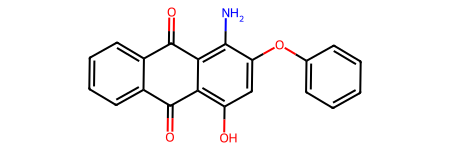

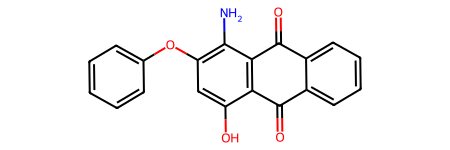

In [31]:
df_ = df.sample(1)
display(Chem.MolFromInchi(df_['inchi'].values[0]))
display(Chem.MolFromSmiles(df_['smiles'].values[0]))

In [33]:
df.to_csv('../data/data/MassSpecGym.tsv', index=False, sep='\t')

In [34]:
save_as_mgf(spectra_new, '../data/data/auxiliary/MassSpecGym.mgf')